In [1]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt

In [2]:
RS = 42

## Random Forest

Выяснили:
1. Отношение сплита тренировочных данных особо на результат не влияет, то есть неравномерности в выборке нет.
2. Удаление коррелирующих параметров сильно на результат не влияет, только на скорость обучения. Разве что если удалить много параметров, показатели сильно ухудшаются.
3. Андерсэмплинг датасета чуть лучше чем балансировка весов, но с балансировкой есть возможность увеличить recall.

### 1. Разбиение данных

Accuracy:   0.9385242748326537
Precision:  0.8647887323943662
Recall:     0.466211085801063
F1:         0.605821410952146


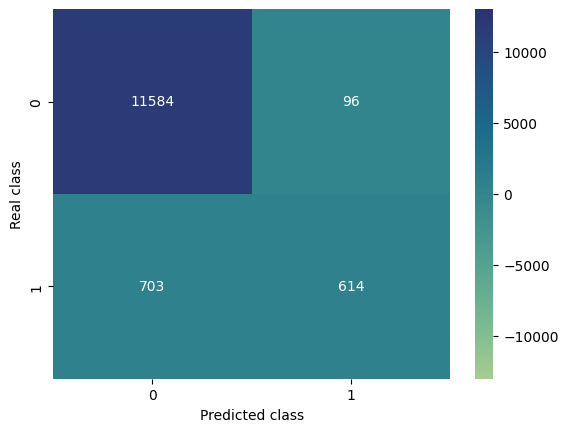

Accuracy:   0.9409622486663931
Precision:  0.8674242424242424
Recall:     0.4753502854177478
F1:         0.6141468320482736


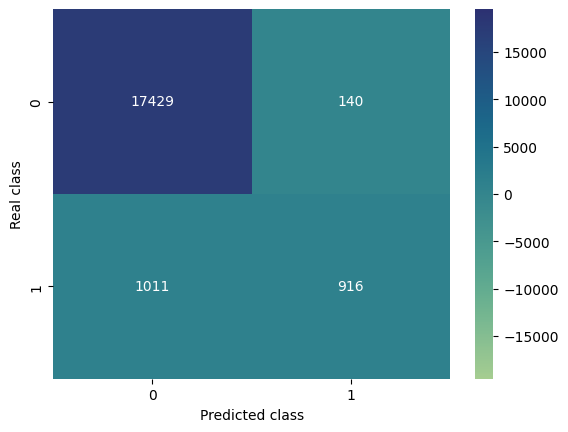

Accuracy:   0.9414480264676464
Precision:  0.8619791666666666
Recall:     0.5026575550493546
F1:         0.6350119904076739


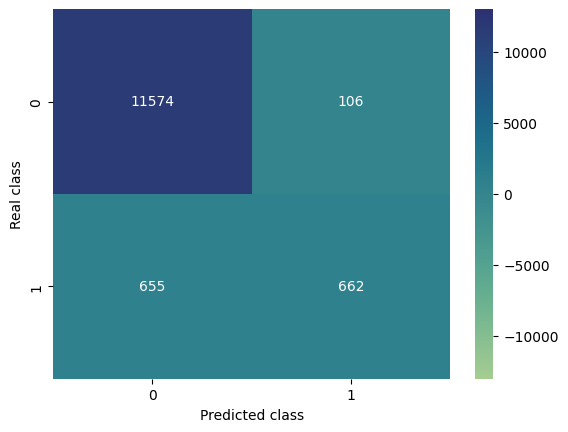

Accuracy:   0.9392695937628232
Precision:  0.8521816562778273
Recall:     0.48455696202531645
F1:         0.617817947062621


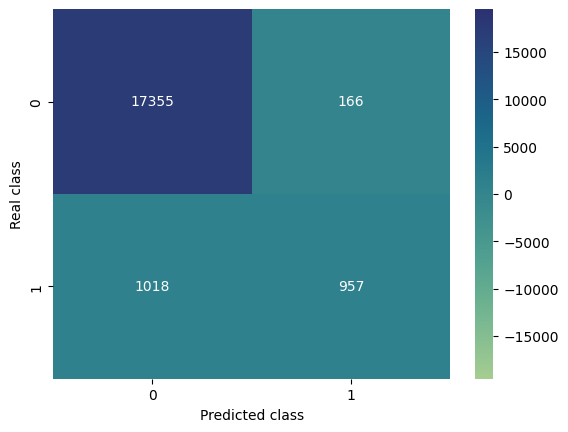

In [3]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

splits = [train_test_split(features, labels, random_state=RS, train_size=0.8),
          train_test_split(features, labels, random_state=RS, train_size=0.7),
          train_test_split(features, labels, random_state=RS, train_size=0.8, stratify=labels),
          train_test_split(features, labels, random_state=RS, train_size=0.7, stratify=labels)]

for sp in splits:
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(sp[0], sp[2])
  metrics(clf.predict(sp[1]), sp[3])

**Recall** показывает насколько много в определенных как переменные переменных.

**Precision** показывает насколько много переменных звезд мы не упустили.

### 2. Коррелирующие параметры

<Axes: >

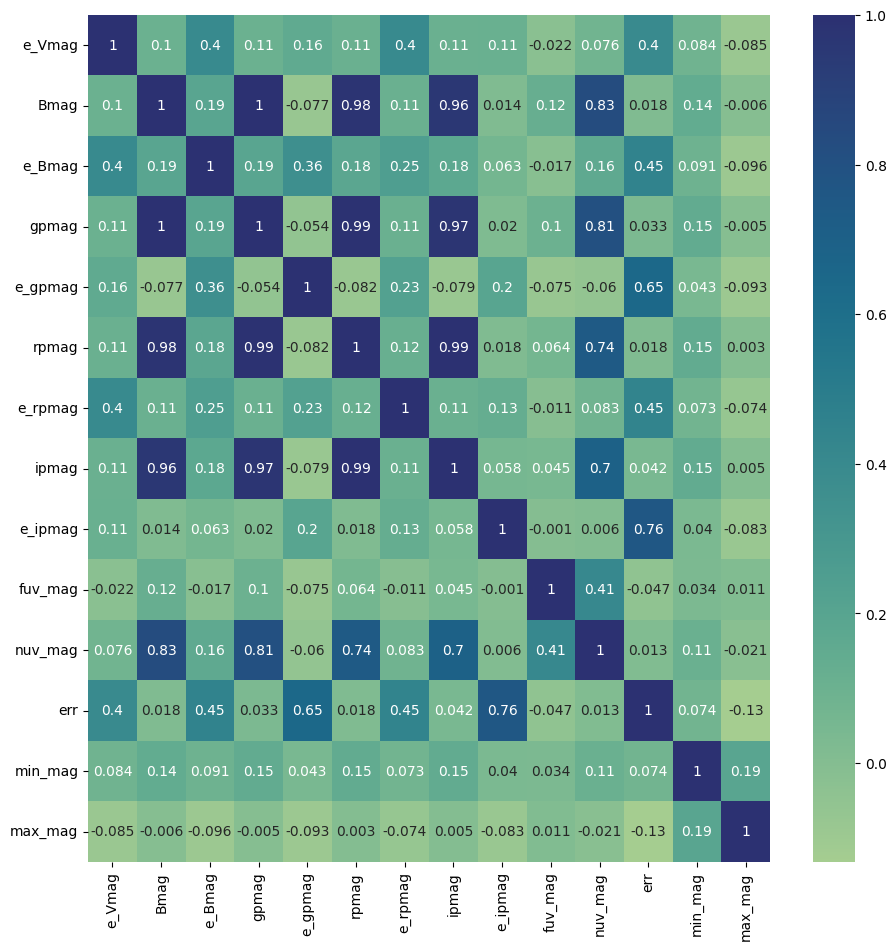

In [4]:
plt.figure(figsize=(11, 11))

corr = features.corr()
sns.heatmap(corr.round(3), cmap="crest", annot=True)

In [5]:
candidates = []  # видно, что связаны одни и те же, поэтому одномерного списка достаточно
treshold = 0.8
for row in corr.iterrows():
  for col in row[1].items():
    if row[0] != col[0] and col[1] > treshold and col[0] not in candidates:
      candidates.append(col[0])

candidates

['gpmag', 'rpmag', 'ipmag', 'nuv_mag', 'Bmag']

Accuracy:   0.9399092098176502
Precision:  0.8839541547277937
Recall:     0.46848899012908124
F1:         0.6124069478908188


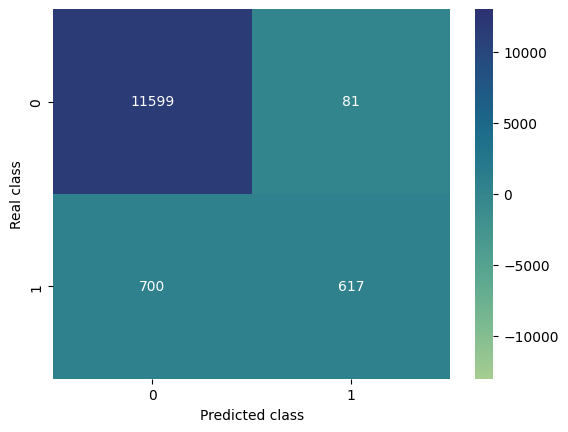

Accuracy:   0.9373701623451566
Precision:  0.8935837245696401
Recall:     0.43356112376613515
F1:         0.5838445807770961


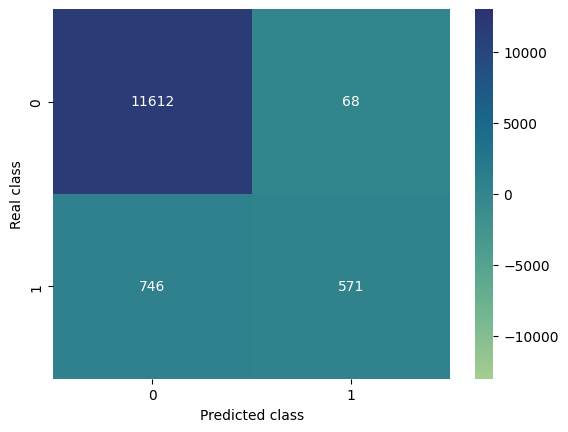

Accuracy:   0.9286758482726784
Precision:  0.877906976744186
Recall:     0.3439635535307517
F1:         0.49427168576104746


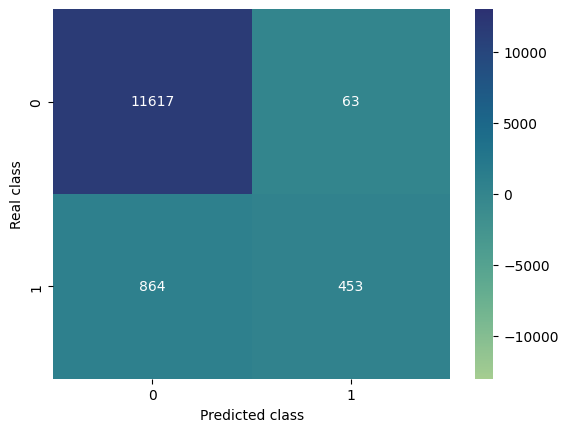

Accuracy:   0.9193660075402016
Precision:  0.8530183727034121
Recall:     0.24677296886864086
F1:         0.3828032979976443


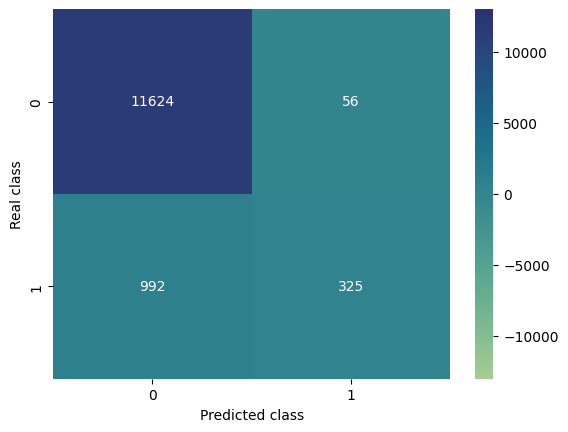

In [6]:
features_copy = features.copy()
# хотя бы один из связанных должен остаться
draw_data = []
for c in candidates[:-1]:
  features_copy.drop(c, inplace=True, axis=1)
  sp = train_test_split(features_copy, labels, random_state=RS, train_size=0.8)
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(sp[0], sp[2])
  draw_data.append(metrics(clf.predict(sp[1]), sp[3]))
  draw_data[-1]["Deleted"] = c

# sns.relplot(draw_data)
# можно понять, что nuv_magnitude is important

<Axes: xlabel='Deleted'>

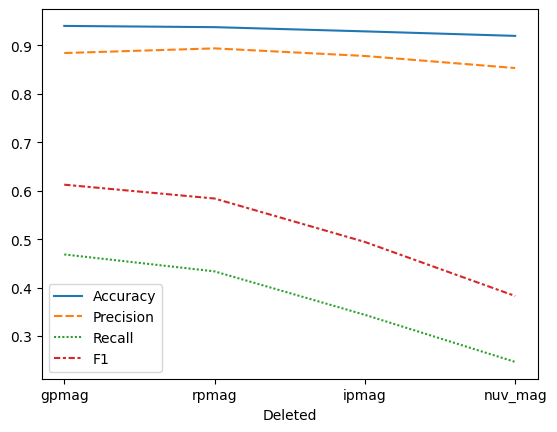

In [7]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Deleted"])
sns.lineplot(draw_df)

### 3. Undersmapling vs balanced

In [8]:
X, x, Y, y = train_test_split(features, labels, random_state=RS, train_size=0.8)

classes = Y.unique()
weights = [compute_class_weight('balanced', classes=classes, y=Y)]
weights

[array([0.55636772, 4.93516233])]

With weight [0.55636772 4.93516233]
Accuracy:   0.9381395706701546
Precision:  0.8904109589041096
Recall:     0.44419134396355353
F1:         0.5927051671732523


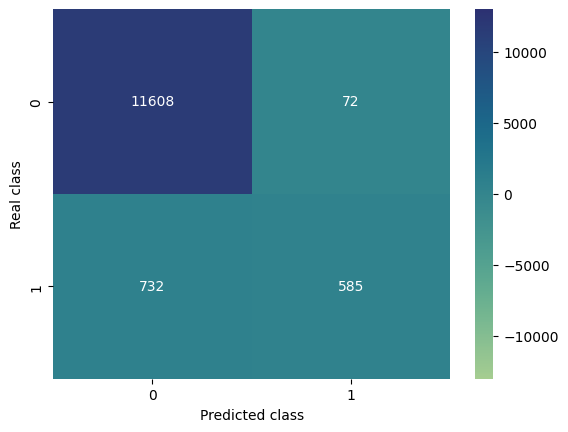

With weight [1, 20]
Accuracy:   0.9372162806801569
Precision:  0.9033816425120773
Recall:     0.42596810933940776
F1:         0.5789473684210527


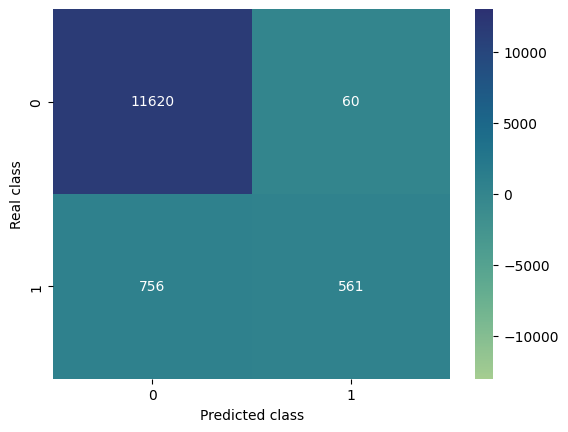

With weight [1, 30]
Accuracy:   0.9368315765176579
Precision:  0.8949044585987261
Recall:     0.4267274107820805
F1:         0.5778920308483291


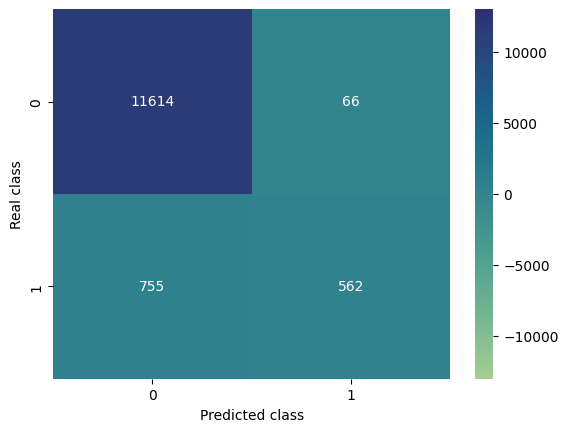

With weight [1, 60]
Accuracy:   0.9352927598676618
Precision:  0.8901639344262295
Recall:     0.4123006833712984
F1:         0.5635703165542294


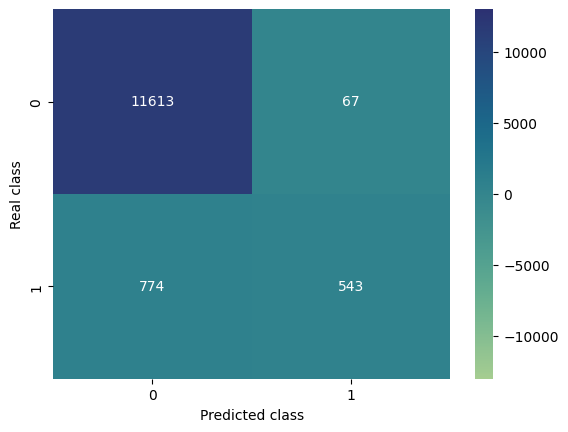

In [9]:
weights += [[1, 20], [1, 30], [1, 60]]

# в декоратор бы это все)
draw_data = []
for w in weights:
  clf = RandomForestClassifier(class_weight=dict(zip(classes, w)), n_jobs=-1)
  clf.fit(X, Y)
  print(f"With weight {w}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["Weights"] = round(w[1] / w[0], 2)

Видно, что веса особо эффекта не приносят

<Axes: xlabel='Weights'>

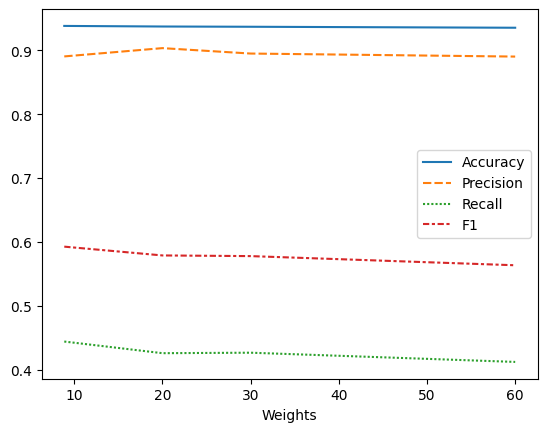

In [10]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Weights"])
sns.lineplot(draw_df)

Try different split ratios for undersampling training

Undersmapling with ratio 1/1
Accuracy:   0.8733553897053166
Precision:  0.44230094703612766
Recall:     0.9574791192103265
F1:         0.6050863723608445


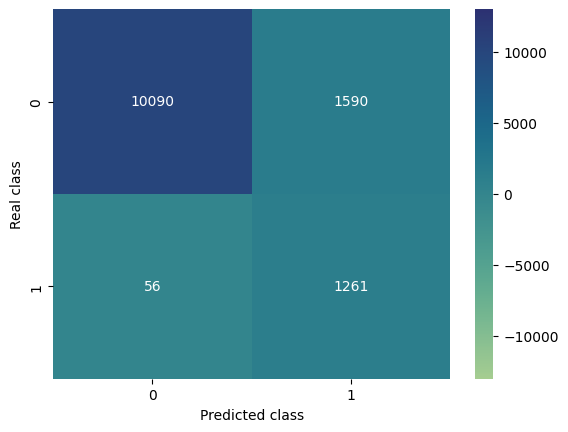

Undersmapling with ratio 1/2
Accuracy:   0.9303685465876741
Precision:  0.610752688172043
Recall:     0.8625664388762339
F1:         0.715140069247718


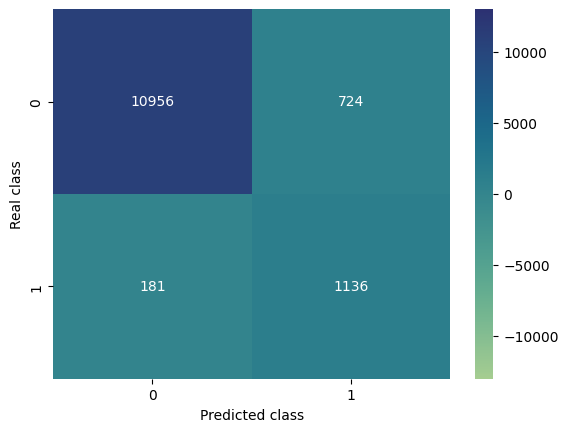

Undersmapling with ratio 1/3
Accuracy:   0.9417557897976456
Precision:  0.6909959072305594
Recall:     0.7691723614274867
F1:         0.72799137621272


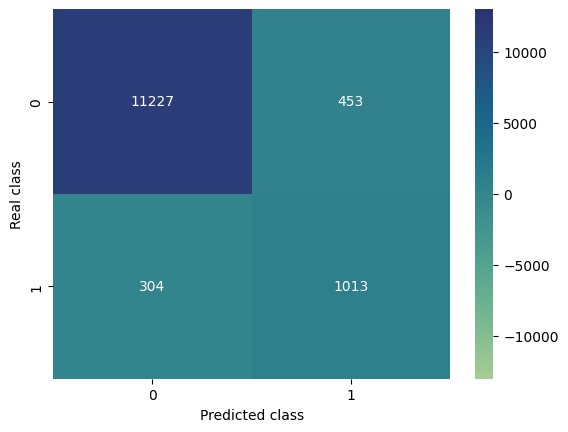

Undersmapling with ratio 1/4
Accuracy:   0.9461414172501347
Precision:  0.7555923777961889
Recall:     0.6924829157175398
F1:         0.722662440570523


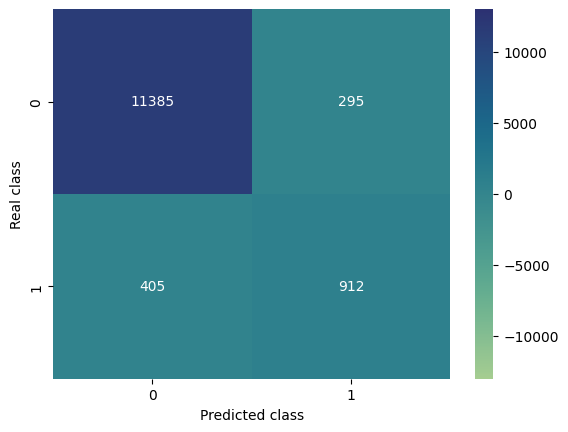

In [11]:
N = Y[Y == 1].size  # number of variable stars
new_train = pd.concat([X, Y], axis=1)

draw_data = []
for r in [1, 2, 3, 4]:
  _temp = pd.concat([new_train[new_train.present == 0].sample(N * r),
                     new_train[new_train.present == 1].sample(N)])
  X, Y = _temp.drop("present", axis=1), _temp["present"]
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(X, Y)
  print(f"Undersmapling with ratio 1/{r}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["Ratio"] = r

<Axes: xlabel='Ratio'>

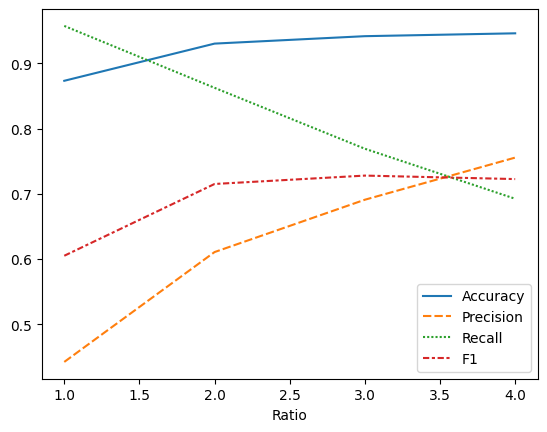

In [12]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Ratio"])
sns.lineplot(draw_df)

### Hyperparameter tuning

Будем тренировать не с балансировкой, а с меньшим датасетом, так как он показывает результаты получше. Ну может это и странно, что я опираюсь на результаты для теста, надо потом проверить с другим рандомным состоянием.

Балансировку выберем не 1/1, опять же по тесту, видимо есть золотая середина между размером выборки и ее сбалансированностью.

In [13]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                     new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [22]:
params = {
  "n_estimators": [100, 300, 500],
  "max_depth": [8, 16, 32],  # FIXME: maybe too deep??
  # "min_samples_leaf" minimum samples from dataset for a node
  # "min_samples_split": [],  let's say we don't need simple trees, but overfitting?
  "n_jobs": [-1]
}

clf = GridSearchCV(RandomForestClassifier(), params)
clf.fit(X, Y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 16, 32],
                         'n_estimators': [100, 300, 500], 'n_jobs': [-1]})

Этот результат более надежный, так как модели при тренировке проходили кросс-валидацию, значит мы, условно, не подбирали параметры по тестовой выборке.

Матрица стала намного лучше, теперь отношение True positive и False negative гораздо удобоваримее.

Accuracy:   0.9417557897976456
Precision:  0.6854304635761589
Recall:     0.785876993166287
F1:         0.7322249734701096


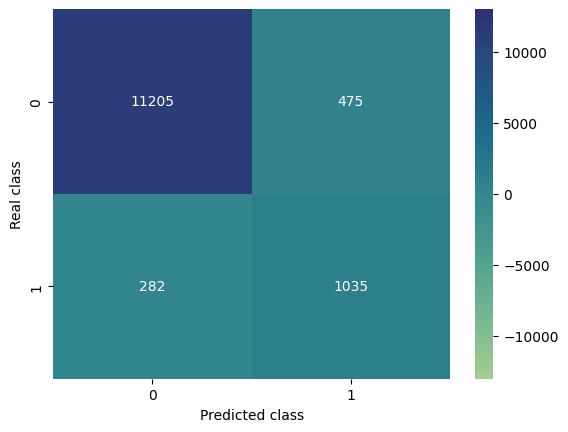

In [23]:
metrics(clf.best_estimator_.predict(x), y, to_return=False)

### Combine high recall and high precision

In [24]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                   new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [25]:
params = {
    "n_estimators": [200],
    "class_weight": [{1: 10}, {1: 20}, {1: 40}],  # high penalty for false positive
    "max_depth": [8, 16],
}
rf_precision = GridSearchCV(RandomForestClassifier(
), params, scoring='precision', n_jobs=-1).fit(X, Y).best_estimator_
rf_precision

KeyboardInterrupt: 

Accuracy:   0.8647380164653381
Precision:  0.42325095718760875
Recall:     0.9233105542900532
F1:         0.5804295942720764


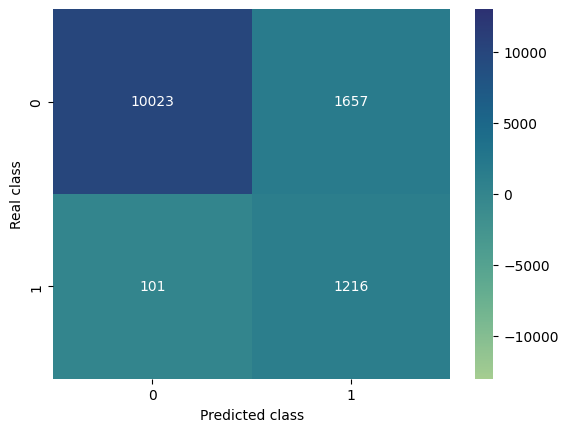

In [17]:
metrics(rf_precision.predict(x), y, to_return=False)

In [18]:
params = {
    "n_estimators": [200],
    "class_weight": [{0: 10}, {0: 20}, {0: 40}],  # high penalty for FN
    "max_depth": [8, 16]
}
rf_recall = GridSearchCV(RandomForestClassifier(
), params, scoring='recall', n_jobs=-1).fit(X, Y).best_estimator_
rf_recall

RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200)

Accuracy:   0.9254443333076864
Precision:  0.7566371681415929
Recall:     0.3895216400911162
F1:         0.5142857142857142


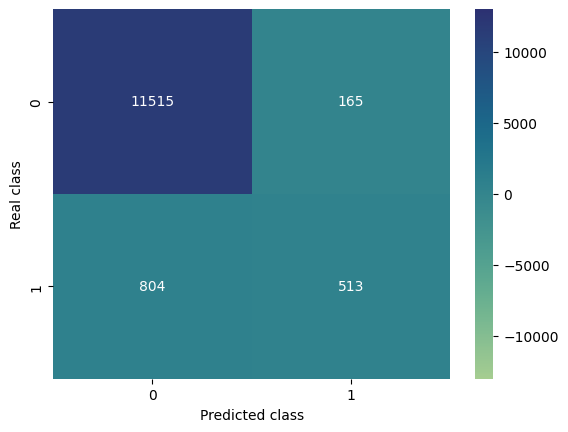

In [19]:
metrics(rf_recall.predict(x), y, to_return=False)

In [20]:
ensemble = VotingClassifier(
    estimators=[
        ('precision_model', RandomForestClassifier(class_weight={1: 10}, max_depth=16, n_estimators=200)),
        ('recall_model', RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200))
    ],
    voting='hard'  # just majority vote
)

ensemble.fit(X, Y)

VotingClassifier(estimators=[('precision_model',
                              RandomForestClassifier(class_weight={1: 10},
                                                     max_depth=16,
                                                     n_estimators=200)),
                             ('recall_model',
                              RandomForestClassifier(class_weight={0: 10},
                                                     max_depth=16,
                                                     n_estimators=200))])

Accuracy:   0.9262906824651843
Precision:  0.789983844911147
Recall:     0.3712984054669704
F1:         0.5051652892561983


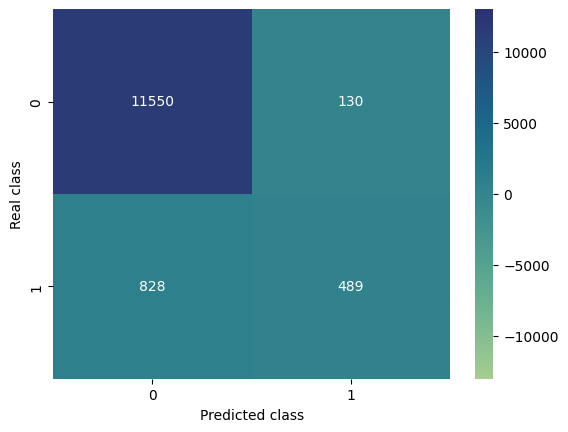

In [21]:
metrics(ensemble.predict(x), y, to_return=False)